In [124]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import scorecardpy as sc
import pprint

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [125]:
df_main = pd.read_csv('filtered_data_iter2.csv')
df = df_main.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114755 entries, 0 to 114754
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                114755 non-null  int64  
 1   STATUS                    114755 non-null  int64  
 2   NAME_CONTRACT_TYPE        114755 non-null  object 
 3   FLAG_OWN_CAR              114755 non-null  object 
 4   FLAG_OWN_REALTY           114755 non-null  object 
 5   AMT_INCOME_TOTAL          114755 non-null  float64
 6   AMT_CREDIT                114755 non-null  float64
 7   AMT_ANNUITY               114755 non-null  float64
 8   NAME_INCOME_TYPE          114755 non-null  object 
 9   NAME_EDUCATION_TYPE       114755 non-null  object 
 10  NAME_FAMILY_STATUS        114755 non-null  object 
 11  NAME_HOUSING_TYPE         114755 non-null  object 
 12  DAYS_EMPLOYED             114755 non-null  int64  
 13  OCCUPATION_TYPE           114755 non-null  o

In [126]:
#replace value 0 in status with 2
# df["STATUS"].replace(0,2,inplace=True)
# df["STATUS"].replace(1,0,inplace=True)
# df["STATUS"].replace(2,1,inplace=True)
df["STATUS"].value_counts()


0    104221
1     10534
Name: STATUS, dtype: int64

In [127]:
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0                  0
STATUS                      0
NAME_CONTRACT_TYPE          0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
AMT_INCOME_TOTAL            0
AMT_CREDIT                  0
AMT_ANNUITY                 0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_EMPLOYED               0
OCCUPATION_TYPE             0
CNT_FAM_MEMBERS             0
EXT_SOURCE_2                0
DEF_60_CNT_SOCIAL_CIRCLE    0
age                         0
dtype: int64

In [128]:
data_dict = {}
for col in df.columns:
    data_dict[col] = [str(df[col].dtypes)]
    

# Manual Encoding so that the order is relevant

In [129]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].map({'Low-skill Laborers': 1, 'Cooking staff': 2, 'Cleaning staff': 3, 'Security staff': 4, 'Waiters/barmen staff': 5, 'Laborers': 6, 'Drivers': 7, 'Sales staff': 8, 'Realty agents': 9, 'Secretaries': 10, 'Not Specified': 11, 'Medicine staff': 12, 'Managers': 13, 'High skill tech staff': 14, 'HR staff': 15, 'Core staff': 16, 'Private service staff': 17, 'Accountants': 18, 'IT staff': 19})

# Education labels are in order of increasing education level
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map({'Lower secondary': 1, 'Secondary / secondary special': 2, 'Incomplete higher': 3, 'Higher education': 4, 'Academic degree': 5})

# Income labels are in order of increasing income level
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].map({'Student': 1, 'Pensioner': 2, 'Working': 3, 'State servant': 4, 'Commercial associate': 5, 'Businessman': 6})

# Housing labels are in order of increasing loan burden on the individual
df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].map({'With parents': 1, 'Rented apartment': 2, 'Municipal apartment': 3, 'Office apartment': 4, 'Co-op apartment': 5, 'House / apartment': 6})

# Label encode the rest that is not manually set.

In [130]:
manual_encodings = ['OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE']

# define the target variable
target = df['STATUS']

# create a list of object columns
object_list = [col for col in df.columns if df[col].dtype == 'object']

# create a dictionary to store the original categorical variables and their encoded values
df_label_encoded = df.copy()
# label encode all object columns and store the original categorical variables and their encoded values
for col in (set(object_list) - set(manual_encodings)):
    print(col)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# label encode the target variable and add it to the dictionary
le = LabelEncoder()
target = le.fit_transform(target)

NAME_CONTRACT_TYPE
FLAG_OWN_REALTY
FLAG_OWN_CAR
NAME_FAMILY_STATUS


In [131]:
del df['Unnamed: 0']
df.drop("FLAG_OWN_REALTY",axis=1,inplace=True) #0.000004 we know this from previous notebook.
df.head()

,STATUS,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_2,DEF_60_CNT_SOCIAL_CIRCLE,age
0,0,0,1,171000.0,1560726.0,41301.0,5,4,1,6,-3130,18,3.0,0.724000,0.0,37.0
1,0,0,0,112500.0,652500.0,21177.0,3,4,1,6,-679,16,3.0,0.651862,0.0,27.0
2,0,0,0,67500.0,80865.0,5881.5,3,2,1,6,-2717,6,2.0,0.715042,0.0,36.0
3,0,0,1,225000.0,918468.0,28966.5,3,2,1,6,-3028,7,3.0,0.566907,0.0,38.0
4,0,0,0,108000.0,509602.5,26149.5,3,2,1,6,-1317,7,2.0,0.236378,0.0,35.0


In [132]:
len(df.columns)
print(df.columns) #exlucing status, we have 15 characteristics

Index(['STATUS', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_EMPLOYED',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'age'],
      dtype='object')


In [133]:
print(df.shape)
df.head()

(114564, 16)


,STATUS,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_2,DEF_60_CNT_SOCIAL_CIRCLE,age
0,0,0,1,171000.0,1560726.0,41301.0,5,4,1,6,-3130,18,3.0,0.724000,0.0,37.0
1,0,0,0,112500.0,652500.0,21177.0,3,4,1,6,-679,16,3.0,0.651862,0.0,27.0
2,0,0,0,67500.0,80865.0,5881.5,3,2,1,6,-2717,6,2.0,0.715042,0.0,36.0
3,0,0,1,225000.0,918468.0,28966.5,3,2,1,6,-3028,7,3.0,0.566907,0.0,38.0
4,0,0,0,108000.0,509602.5,26149.5,3,2,1,6,-1317,7,2.0,0.236378,0.0,35.0


# Select best bins identified in notebook 3

In [134]:
breaks_adj = {
       'OCCUPATION_TYPE' : [1,  6, 9],
    'NAME_HOUSING_TYPE': [4],
       'NAME_INCOME_TYPE' : [4,5],
        'NAME_EDUCATION_TYPE' : [3],
        'AMT_INCOME_TOTAL' : [90000,200000,250000, 300000],
    
        'DAYS_EMPLOYED' : [-5000,-3500, -2200, -1700, -1000],
        'AMT_ANNUITY' : [12000, 16000],
        'EXT_SOURCE_2' : [0.14,0.25,0.35,0.6],
        'AMT_CREDIT' : [150000,200000,250000, 300000],
        'CNT_FAM_MEMBERS' : [1,2,3],
        'NAME_FAMILY_STATUS' : [0,3],
        'age' : [27, 30,35, 40],
        'DEF_60_CNT_SOCIAL_CIRCLE' : [0,1],
        'FLAG_OWN_CAR': [0,1]
    }
bins_final = sc.woebin(df, y='STATUS',breaks_list=breaks_adj)
# bins_final = sc.woebin(df, y='STATUS',breaks_list=breaks_adj, positive="bad|0")

[INFO] creating woe binning ...


# Split dataset

Imbalanced dataset

In [135]:
# sample code
train, test = sc.split_df(df, 'STATUS', ratio=0.8).values()
print(train.shape)
print(test.shape)

(91651, 16)
(22913, 16)


In [136]:
print('Proportion of positive cases in train set:', train['STATUS'].mean())
print('Proportion of positive cases in test set:', test['STATUS'].mean())

Proportion of positive cases in train set: 0.09175022640233058
Proportion of positive cases in test set: 0.09173831449395539


In [137]:
train_woe = sc.woebin_ply(train, bins_final)
test_woe = sc.woebin_ply(test, bins_final)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [138]:
y_train = train_woe.loc[:,'STATUS']
X_train = train_woe.loc[:,train_woe.columns != 'STATUS']
y_test = test_woe.loc[:,'STATUS']
X_test = test_woe.loc[:,test_woe.columns != 'STATUS']

RUS

In [139]:
print("Class distribution in original train set:", Counter(y_train))
rus = RandomUnderSampler(random_state=7)
X_train_rus_resampled, y_train_rus_resampled = rus.fit_resample(X_train, y_train)
print("Class distribution in resampled train set:", Counter(y_train_rus_resampled))

Class distribution in original train set: Counter({0: 83242, 1: 8409})
Class distribution in resampled train set: Counter({0: 8409, 1: 8409})


ROS

In [140]:
print("Class distribution in original train set:", Counter(y_train))
ros = RandomOverSampler(random_state=7)
X_train_ros_resampled, y_train_ros_resampled = ros.fit_resample(X_train, y_train)
print("Class distribution in resampled train set:", Counter(y_train_ros_resampled))

Class distribution in original train set: Counter({0: 83242, 1: 8409})
Class distribution in resampled train set: Counter({0: 83242, 1: 83242})


SMOTE

In [141]:
print("Class distribution in original train set:", Counter(y_train))
smote = SMOTE(random_state=7)
X_train_smote_resampled, y_train_smote_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution in resampled train set:", Counter(y_train_smote_resampled))

Class distribution in original train set: Counter({0: 83242, 1: 8409})
Class distribution in resampled train set: Counter({0: 83242, 1: 83242})


# Logistic Regression on imbalanced dataset

In [142]:
#create a logistic regression model object
lr = LogisticRegression(class_weight='balanced', random_state=7)
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[0.88651134 0.77189114 1.23047265 0.46683409 0.34464198 0.66304881
  0.52599453 0.00374765 0.81852242 0.63304963 0.84431062 0.60195003
  0.7349196  0.08355316 0.85442172]]
[-0.00343984]


1 is good
0 is default

In [143]:
accuracy = lr.score(X_test, y_test)
accuracy

0.6515078776240563

In [144]:
# make predictions on the test set
y_pred = lr.predict(X_test)

In [145]:
# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

# create a dataframe from the confusion matrix
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])


# print the dataframe
print(df_cm)

         Predict Good  Predict Default
Good            13634             7177
Default           808             1294


True positive (TP)
The model predicts a good customer, and the client did not default <br>
False positive (FP)
The model predicts a good customer, but the client defaulted<br>
True negative (TN) 
The model predicts a default, and the client defaulted<br>
False negative (FN)
The model predicts a default, but the client did not default

In [146]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13634 7177 808 1294
Accuracy: 0.6515078776240563
Precision: 0.944052070350367
Recall: 0.65513430397386
Specificity: 0.615604186489058
F1: 0.7734944543726775


# Logistic Regression with RUS

In [147]:
lr_rus = LogisticRegression(C=1, solver='liblinear', random_state=7)
lr_rus.fit(X_train_rus_resampled, y_train_rus_resampled)
print(lr_rus.coef_)
print(lr_rus.intercept_)

[[ 0.88358276  0.79679272  1.08094389  0.44288816  0.54255922  0.39350778
   0.52136997 -0.34055509  0.81619787  0.6431738   0.91246964  0.66174219
   0.78555031 -0.06414777  0.69639007]]
[-0.00360519]


In [148]:
y_rus_pred = lr_rus.predict(X_test)
cm = confusion_matrix(y_test, y_rus_pred, labels=[0,1])
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])
print(df_cm)

         Predict Good  Predict Default
Good            13628             7183
Default           807             1295


In [149]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, y_rus_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13628 7183 807 1295
Accuracy: 0.6512896608911971
Precision: 0.9440942154485625
Recall: 0.6548459949065398
Specificity: 0.6160799238820172
F1: 0.7733076093741134


# Logistic Regression with ROS

In [150]:
lr_ros = LogisticRegression(C=1, solver='liblinear', random_state=7)
lr_ros.fit(X_train_ros_resampled, y_train_ros_resampled)
print(lr_ros.coef_)
print(lr_ros.intercept_)

[[0.88825273 0.75233021 1.21096703 0.46945932 0.36659088 0.70738182
  0.51489882 0.06721817 0.84994791 0.63574281 0.81080782 0.61704768
  0.7355601  0.07053362 0.88514373]]
[-0.00503184]


In [151]:
lr_ros_pred = lr_ros.predict(X_test)
cm = confusion_matrix(y_test, lr_ros_pred, labels=[0,1])
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])
print(df_cm)

         Predict Good  Predict Default
Good            13671             7140
Default           820             1282


In [152]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, lr_ros_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13671 7140 820 1282
Accuracy: 0.6525989612883516
Precision: 0.943413152991512
Recall: 0.656912209889001
Specificity: 0.609895337773549
F1: 0.774517024531188


# Logistic Regression with SMOTE

In [153]:
lr_smote = LogisticRegression(C=1, solver='liblinear', random_state=7)
lr_smote.fit(X_train_smote_resampled, y_train_smote_resampled)
print(lr_smote.coef_)
print(lr_smote.intercept_)

[[ 0.88770126  0.84841723  1.79165822  0.4092526   0.63582941  0.07735945
   0.66422918 -1.26231478  0.94324638  0.64240713  1.11100889  0.77404804
   0.59234591  0.40202362  0.63034395]]
[-0.0164379]


In [154]:
y_smote_pred = lr_smote.predict(X_test)
cm = confusion_matrix(y_test, y_smote_pred, labels=[0,1])
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])
print(df_cm)

         Predict Good  Predict Default
Good            13634             7177
Default           803             1299


In [155]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, y_smote_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13634 7177 803 1299
Accuracy: 0.6517260943569153
Precision: 0.9443790261134585
Recall: 0.65513430397386
Specificity: 0.6179828734538535
F1: 0.773604176123468


# Function to maximize specificity

In [156]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
def calculate(y_test,y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
    return tn/(tn+fp)

# Original dataset tuning

In [157]:
numbers = []
for i in range(1, 200):
    numbers.append(i / 100)

best_c = 1
spec = 0.615604186489058

In [158]:
for i in numbers:
    lr = LogisticRegression(random_state=7,C= i, solver= 'liblinear', class_weight='balanced')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    res = calculate(y_test,y_pred)
    if res > spec:
        best_c=i
        spec=res

In [159]:
print(best_c)

0.03


In [160]:
#create a logistic regression model object
lr = LogisticRegression(C=0.03,class_weight='balanced', random_state=7)
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[0.88223218 0.72538468 0.91329877 0.46066271 0.48310425 0.55503607
  0.49996063 0.12944242 0.8047818  0.62208359 0.60641126 0.55218153
  0.69617568 0.08164487 0.75919395]]
[-0.00324876]


In [161]:
# make predictions on the test set
y_pred = lr.predict(X_test)

In [162]:
# assume y_true and y_pred are the true and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

# create a dataframe from the confusion matrix
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])


# print the dataframe
print(df_cm)

         Predict Good  Predict Default
Good            13665             7146
Default           804             1298


In [163]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13665 7146 804 1298
Accuracy: 0.6530353947540697
Precision: 0.944432925565001
Recall: 0.6566239008216809
Specificity: 0.6175071360608944
F1: 0.7746598639455782


# RUS Tuning

In [164]:
numbers = []
for i in range(1, 200):
    numbers.append(i / 100)

best_c = 1
spec = 0.6160799238820172

In [165]:
for i in numbers:
    lr = LogisticRegression(random_state=7,C= i, solver= 'liblinear')
    lr.fit(X_train_rus_resampled, y_train_rus_resampled)
    y_pred = lr.predict(X_test)
    res = calculate(y_test,y_pred)
    if res > spec:
        best_c=i
        spec=res

In [166]:
print(best_c)

0.31


In [167]:
lr_rus = LogisticRegression(C=0.31, solver='liblinear', random_state=7)
lr_rus.fit(X_train_rus_resampled, y_train_rus_resampled)
print(lr_rus.coef_)
print(lr_rus.intercept_)


[[ 0.88193867  0.77578095  0.97450997  0.44096824  0.58009079  0.36978134
   0.51072478 -0.20677284  0.81068203  0.63807826  0.7671796   0.63629899
   0.77302743 -0.06132866  0.66662668]]
[-0.00348941]


In [168]:
y_rus_pred = lr_rus.predict(X_test)
cm = confusion_matrix(y_test, y_rus_pred, labels=[0,1])
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])
print(df_cm)

         Predict Good  Predict Default
Good            13641             7170
Default           805             1297


In [169]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, y_rus_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13641 7170 805 1297
Accuracy: 0.6519443110897744
Precision: 0.9442752318981033
Recall: 0.6554706645524002
Specificity: 0.6170313986679353
F1: 0.7738037836458008


# ROS Tuning

In [170]:
numbers = []
for i in range(1, 200):
    numbers.append(i / 100)

best_c = 1
spec = 0.609895337773549

In [171]:
for i in numbers:
    lr = LogisticRegression(random_state=7,C= i, solver= 'liblinear')
    lr.fit(X_train_ros_resampled, y_train_ros_resampled)
    y_pred = lr.predict(X_test)
    res = calculate(y_test,y_pred)
    if res > spec:
        best_c=i
        spec=res

In [172]:
print(best_c)

0.02


In [173]:
lr = LogisticRegression(random_state=7,C= 0.02, solver= 'liblinear')
lr.fit(X_train_ros_resampled, y_train_ros_resampled)

LogisticRegression(C=0.02, random_state=7, solver='liblinear')

In [174]:
lr_ros_pred = lr_ros.predict(X_test)
cm = confusion_matrix(y_test, lr_ros_pred, labels=[0,1])
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])
print(df_cm)

         Predict Good  Predict Default
Good            13671             7140
Default           820             1282


In [175]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, lr_ros_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13671 7140 820 1282
Accuracy: 0.6525989612883516
Precision: 0.943413152991512
Recall: 0.656912209889001
Specificity: 0.609895337773549
F1: 0.774517024531188


# SMOTE Tuning

In [176]:
numbers = []
for i in range(1, 200):
    numbers.append(i / 100)

best_c = 1
spec = 0.6179828734538535

In [177]:
for i in numbers:
    lr_smote = LogisticRegression(C=i, solver='liblinear', random_state=7)
    lr_smote.fit(X_train_smote_resampled, y_train_smote_resampled)
    y_pred = lr_smote.predict(X_test)
    res = calculate(y_test,y_pred)
    if res > spec:
        best_c=i
        spec=res

In [178]:
print(best_c)

0.05


In [179]:
#create a logistic regression model object
lr_smote = LogisticRegression(C=0.05, solver='liblinear', random_state=7)
lr_smote.fit(X_train_smote_resampled, y_train_smote_resampled)
print(lr.coef_)
print(lr.intercept_)

[[0.88474043 0.71400612 0.93471614 0.46417075 0.4891802  0.60964184
  0.49307399 0.15830088 0.83744669 0.62641089 0.61588523 0.57592256
  0.70178516 0.06962928 0.80061472]]
[-0.00479869]


In [180]:
y_smote_pred = lr_smote.predict(X_test)
cm = confusion_matrix(y_test, y_smote_pred, labels=[0,1])
df_cm = pd.DataFrame(cm, index=['Good', 'Default'], columns=['Predict Good', 'Predict Default'])
print(df_cm)

         Predict Good  Predict Default
Good            13662             7149
Default           801             1301


In [181]:
#import accuracy score from sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
tp, fn, fp, tn = confusion_matrix(y_test, y_smote_pred, labels=[0,1]).ravel()
print(tp,fn,fp,tn)

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) #Given that we predict positive, how often is it really positive
recall = tp / (tp + fn) #How good at predicting positive
f1 = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp) # How good at predicting negative?

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity) 
print("F1:", f1)

13662 7149 801 1301
Accuracy: 0.6530353947540697
Precision: 0.9446172993154948
Recall: 0.6564797462880207
Specificity: 0.6189343482397717
F1: 0.7746215342745366


# Let us see the results

BEST SMOTE
<br> 
Accuracy: 0.6530353947540697<br> 
Precision: 0.9446172993154948<br> 
Recall: 0.6564797462880207<br> 
Specificity: 0.6189343482397717<br> 
F1: 0.7746215342745366
<br>
    
BEST ROS
<br>
Accuracy: 0.6525989612883516<br>
Precision: 0.943413152991512<br>
Recall: 0.656912209889001<br>
Specificity: 0.609895337773549<br>
F1: 0.774517024531188


<br> 
    
BEST RUS
<br> 
Accuracy: 0.6519443110897744<br> 
Precision: 0.9442752318981033<br> 
Recall: 0.6554706645524002<br> 
Specificity: 0.6170313986679353<br> 
F1: 0.7738037836458008



BEST ORIGINAL DATASET (imbalanced)
<br>
Accuracy: 0.6530353947540697<br>
Precision: 0.944432925565001<br>
Recall: 0.6566239008216809<br>
Specificity: 0.6175071360608944<br>
F1: 0.7746598639455782

# Comparing Results

Best Accuracy: <br>
BEST SMOTE (0.653) /  BEST ORIGINAL DATASET (0.653)<br>


Best Precision:<br>
BEST SMOTE (0.945)<br>

Best Recall:<br>
BEST ROS (0.657) / BEST ORIGINAL DATASET (0.657)<br>

Best Specificity:<br>
BEST SMOTE (0.619)<br>

Best F1 Score:<br>
BEST ORIGINAL DATASET (0.775) / BEST SMOTE (0.775)<br>

All methods had not much difference. The difference were in the 3 or 4 decimal places. SMOTE and the original dataset had similar performances. After looking at the ROC, we decided to go with the original dataset.

Original Dataset


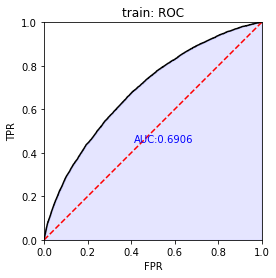

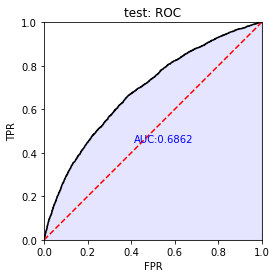

SMOTE


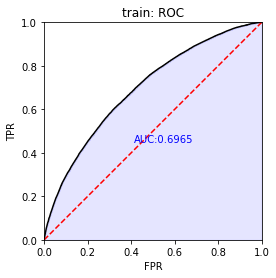

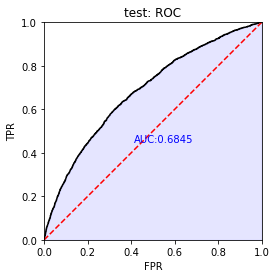

In [191]:
print("Original Dataset")
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]


train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")

print("SMOTE")
train_pred = lr_smote.predict_proba(X_train_smote_resampled)[:,1]
test_pred = lr_smote.predict_proba(X_test)[:,1]

train_perf = sc.perf_eva(y_train_smote_resampled, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")

# We will select the LR trained with the original dataset

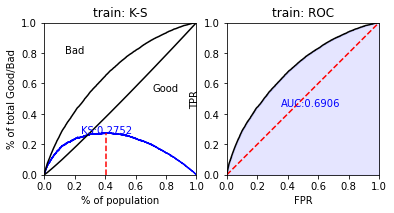

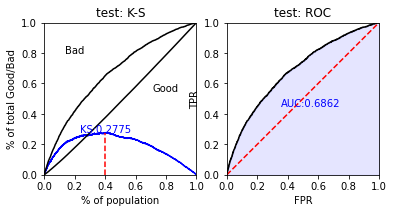

In [192]:
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# Creating Scorecard with original dataset

In [208]:
#generate a card from the model and bins. The scores will be based on probability of default from the model
card = sc.scorecard(bins_final, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20,
      basepoints_eq0 = False)

pprint.pprint(card)

{'AMT_ANNUITY':       variable                bin  points
0  AMT_ANNUITY     [-inf,12000.0)     4.0
1  AMT_ANNUITY  [12000.0,16000.0)     2.0
2  AMT_ANNUITY      [16000.0,inf)    -1.0,
 'AMT_CREDIT':       variable                  bin  points
28  AMT_CREDIT      [-inf,150000.0)     9.0
29  AMT_CREDIT  [150000.0,200000.0)     4.0
30  AMT_CREDIT  [200000.0,250000.0)     2.0
31  AMT_CREDIT  [250000.0,300000.0)     0.0
32  AMT_CREDIT       [300000.0,inf)    -1.0,
 'AMT_INCOME_TOTAL':             variable                  bin  points
14  AMT_INCOME_TOTAL       [-inf,90000.0)    -0.0
15  AMT_INCOME_TOTAL   [90000.0,200000.0)    -0.0
16  AMT_INCOME_TOTAL  [200000.0,250000.0)     0.0
17  AMT_INCOME_TOTAL  [250000.0,300000.0)     0.0
18  AMT_INCOME_TOTAL       [300000.0,inf)     1.0,
 'CNT_FAM_MEMBERS':            variable         bin  points
11  CNT_FAM_MEMBERS  [-inf,2.0)    -2.0
12  CNT_FAM_MEMBERS   [2.0,3.0)    -1.0
13  CNT_FAM_MEMBERS   [3.0,inf)     1.0,
 'DAYS_EMPLOYED':          varia

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

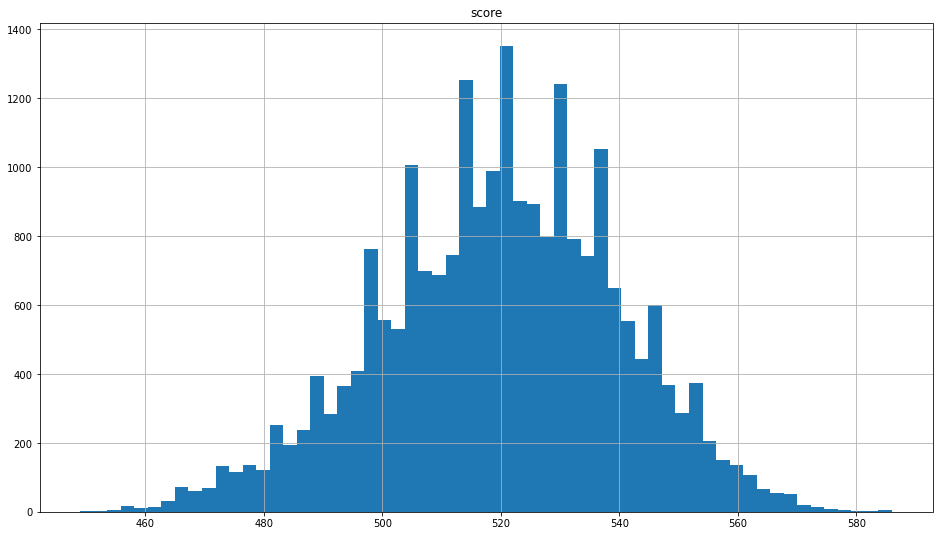

In [209]:
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

#distrubution of scores on test data
test_score.hist(figsize=(16,9),bins=60)

In [210]:
temp_df = pd.DataFrame()

for key in card:
    if key != 'basepoints':
        temp_df = temp_df.append(card[key], ignore_index=True)
        
temp_df['bin'] = temp_df['bin'].apply(lambda x: str(x).replace('[','').replace(')',''))

for i in range(0, len(temp_df)):
    value = str(temp_df.iloc[i]['bin'])
    value_list = value.split(',')
    if str(value_list[0]) == '-inf':
        value = '<' + value_list[1]
    elif str(value_list[1]) == 'inf':        
        value = ">"+value_list[0]
    temp_df.at[i,'bin'] = value

temp_df.to_csv('scorecard.csv', index=False)

Without base

In [211]:
#generate a card from the model and bins. The scores will be based on probability of default from the model
card = sc.scorecard(bins_final, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20,
      basepoints_eq0 = True)

pprint.pprint(card)

{'AMT_ANNUITY':       variable                bin  points
0  AMT_ANNUITY     [-inf,12000.0)    38.0
1  AMT_ANNUITY  [12000.0,16000.0)    36.0
2  AMT_ANNUITY      [16000.0,inf)    34.0,
 'AMT_CREDIT':       variable                  bin  points
28  AMT_CREDIT      [-inf,150000.0)    43.0
29  AMT_CREDIT  [150000.0,200000.0)    38.0
30  AMT_CREDIT  [200000.0,250000.0)    37.0
31  AMT_CREDIT  [250000.0,300000.0)    35.0
32  AMT_CREDIT       [300000.0,inf)    33.0,
 'AMT_INCOME_TOTAL':             variable                  bin  points
14  AMT_INCOME_TOTAL       [-inf,90000.0)    34.0
15  AMT_INCOME_TOTAL   [90000.0,200000.0)    34.0
16  AMT_INCOME_TOTAL  [200000.0,250000.0)    34.0
17  AMT_INCOME_TOTAL  [250000.0,300000.0)    35.0
18  AMT_INCOME_TOTAL       [300000.0,inf)    35.0,
 'CNT_FAM_MEMBERS':            variable         bin  points
11  CNT_FAM_MEMBERS  [-inf,2.0)    32.0
12  CNT_FAM_MEMBERS   [2.0,3.0)    34.0
13  CNT_FAM_MEMBERS   [3.0,inf)    36.0,
 'DAYS_EMPLOYED':          varia

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

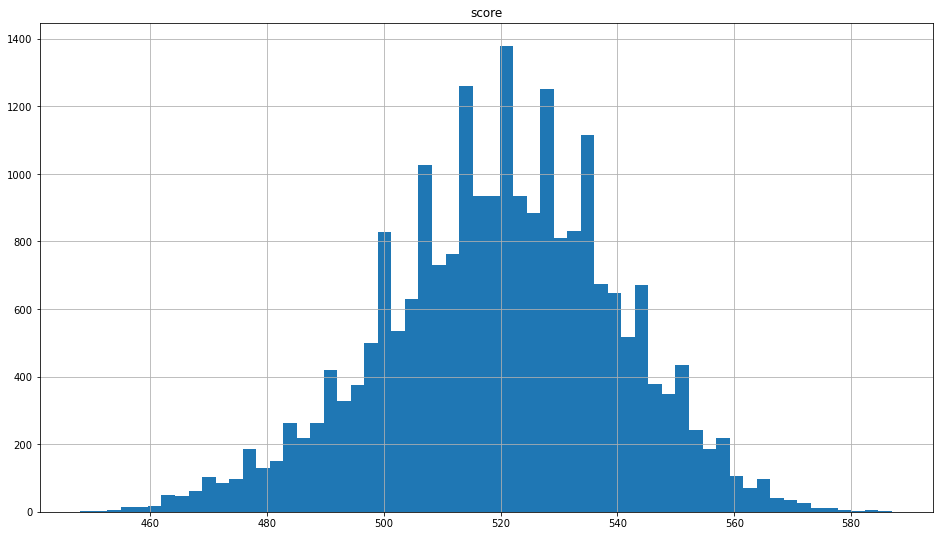

In [212]:
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

#distrubution of scores on test data
test_score.hist(figsize=(16,9),bins=60)

In [213]:
temp_df = pd.DataFrame()

for key in card:
    if key != 'basepoints':
        temp_df = temp_df.append(card[key], ignore_index=True)
        
temp_df['bin'] = temp_df['bin'].apply(lambda x: str(x).replace('[','').replace(')',''))

for i in range(0, len(temp_df)):
    value = str(temp_df.iloc[i]['bin'])
    value_list = value.split(',')
    if str(value_list[0]) == '-inf':
        value = '<' + value_list[1]
    elif str(value_list[1]) == 'inf':        
        value = ">"+value_list[0]
    temp_df.at[i,'bin'] = value

temp_df.to_csv('scorecard_base.csv', index=False)